In [1]:
import math
import numpy as np
import random
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
goal_states = [1, 2]
size_of_maze = 4
episodes = 100000

discount = 0.9
alpha = 0.01
e_soft = 0.01

n = 256

inputs = n
ouputs = 1

reward_bad = -1
reward_good = 0

In [3]:
def hrr(length, normalized=False):
    if normalized:
        x = np.random.uniform(-np.pi,np.pi,int((length-1)/2))
        if length % 2:
            x = np.real(np.fft.ifft(np.concatenate([np.ones(1), np.exp(1j*x), np.exp(-1j*x[::-1])])))
        else:
            x = np.real(np.fft.ifft(np.concatenate([np.ones(1), np.exp(1j*x), np.ones(1), np.exp(-1j*x[::-1])])))
    else:
        x = np.random.normal(0.0, 1.0/np.sqrt(length), length)
    return x

In [4]:
state_hrrs = np.zeros([size_of_maze, n])
for x in range(size_of_maze):
    state_hrrs[x] = hrr(n, True)

identity_hrr = np.zeros(n)
identity_hrr[0] = 1

color_hrrs_internal = np.zeros([len(goal_states), n])
color_hrrs_external = np.zeros([len(goal_states), n])
for x in range(len(goal_states)):
    color_hrrs_internal[x] = hrr(n, True)
    color_hrrs_external[x] = hrr(n, True)
possible_signals = np.vstack((identity_hrr, color_hrrs_external))
possible_wm = np.vstack((identity_hrr, color_hrrs_internal))

In [5]:
def convolve(x, y):
    return np.real(np.fft.ifft(np.fft.fft(x)*np.fft.fft(y)))

def preconvolve():
    preconvolved_matrix = np.zeros([possible_signals.size, possible_wm.size, size_of_maze, n])
    for x in range(len(possible_signals)):
        for y in range(len(possible_wm)):
            for z in range(size_of_maze):
                preconvolved_matrix[x][y][z] = convolve(possible_signals[x], convolve(possible_wm[y], state_hrrs[z]))
    return preconvolved_matrix

In [6]:
def policy(state_left, state_right, wm, color, signal, rand_on):
    # Calculates the value of each possible decision
    # Value of stepping left with signal and with signal and wm
    value_left_state_x = nn.feedforward(preconvolved_matrix[signal][0][state_left])
    value_left_state_wm = nn.feedforward(preconvolved_matrix[signal][wm][state_left])
    
    # Value of stepping right with signal and with signal and wm
    value_right_state_x = nn.feedforward(preconvolved_matrix[signal][0][state_right])
    value_right_state_wm = nn.feedforward(preconvolved_matrix[signal][wm][state_right])
    
    # Random move
    if((np.random.random() < e_soft) and (rand_on == 1)):
        return np.random.choice([-1, 1]), wm
    
    # Properly sets signal to the repective internal value
    if(not (np.array_equal(signal, identity_hrr))):
        internal_color = color + 1
    
    # Calculates max value
    max_value = max(value_left_state_x, value_left_state_wm, value_right_state_x, value_right_state_wm)
    
    # Figures out what to return
    if(max_value == value_left_state_x):
        return -1, internal_color
    elif(max_value == value_left_state_wm):
        return -1, wm
    elif(max_value == value_right_state_x):
        return 1, internal_color
    elif(max_value == value_right_state_wm):
        return 1, wm

In [7]:
class NeuralNetwork:
    def __init__(self, inputs, outputs, discount, alpha):
        self.discount = discount
        self.alpha = alpha
        self.input = inputs
        self.output = outputs
        self.weights = hrr(n, True)
        self.bias = 0
        
    def feedforward(self, X):
        self.output = np.dot(self.weights, X) + self.bias
        return self.output
    
    def backprop(self, state_prime_hrr, state_hrr, y):
        if(y == reward_good):
            self.error = reward_good - self.feedforward(state_hrr)
            self.weights = np.add(self.weights, (self.alpha * self.error * state_hrr))
        else:
            self.error = (reward_bad + self.discount * self.feedforward(state_hrr)) - self.feedforward(state_prime_hrr)
            self.weights = np.add(self.weights, (self.alpha * self.error * state_prime_hrr))

In [8]:
preconvolved_matrix = preconvolve()
nn = NeuralNetwork(n, 1, discount, alpha)

In [ ]:
state = random.randint(0, size_of_maze - 1)
state_prime = state
rand_color = np.random.choice(len(goal_states))
goal_state = goal_states[rand_color]
signal = rand_color + 1
old_signal = signal
for x in range(episodes):
        wm = 0
        while(state != goal_state):
            old_wm = wm
            color = rand_color
            if(state == 0):
                decision, wm = policy(size_of_maze - 1, 1, wm, color, signal, 1)
                if(decision == -1):
                    state_prime = state
                    state = size_of_maze - 1
                else:
                    state_prime = state
                    state = state + decision
            elif(state == size_of_maze - 1):
                decision, wm = policy(state - 1, 0, wm, color, signal, 1)
                if(decision == -1):
                    state_prime = state
                    state = state + decision
                else:
                    state_prime = state
                    state = 0
            else:
                decision, wm = policy(state - 1, state + 1, wm, color, signal, 1)
                state_prime = state
                state = state + decision
            nn.backprop(preconvolved_matrix[old_signal][old_wm][state_prime], preconvolved_matrix[signal][wm][state], reward_bad)
            old_signal = signal
            signal = 0
        nn.backprop(preconvolved_matrix[old_signal][old_wm][state_prime], preconvolved_matrix[signal][wm][state], reward_good)
        state = random.randint(0, size_of_maze - 1)
        state_prime = state
        rand_color = np.random.choice(len(goal_states))
        goal_state = goal_states[rand_color]
        signal = rand_color + 1
        old_signa = signal
        if((x+1)%10000 == 0):
            print("Episode", x+1, "done")

In [ ]:
position = np.arange(size_of_maze)
value = np.zeros(size_of_maze)
for x in range (np.size(possible_signals, 0)):
    for y in range (np.size(possible_wm, 0)):
        for z in range (size_of_maze):
            value[z] = nn.feedforward(convolve(state_hrrs[z], (convolve(possible_signals[x], possible_wm[y]))))
        plt.plot(position, value) 
        print(np.amax(value))

0.08053441002842285


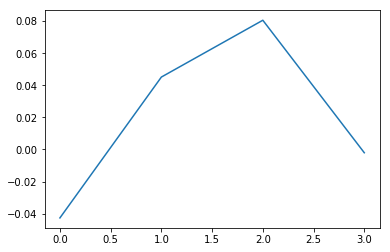

In [10]:
position = np.arange(size_of_maze)
value = np.zeros(size_of_maze)
for z in range (size_of_maze):
    value[z] = nn.feedforward(convolve(state_hrrs[z], possible_wm[1]))
plt.plot(position, value) 
print(np.amax(value))

0.02643953988288096


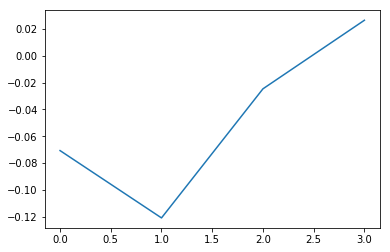

In [11]:
position = np.arange(size_of_maze)
value = np.zeros(size_of_maze)
for z in range (size_of_maze):
    value[z] = nn.feedforward(convolve(state_hrrs[z], possible_wm[2]))
plt.plot(position, value) 
print(np.amax(value))